<h1 style="text-align: center;"><u><b>CSC3066 Deep Learning (Fake News Detection)</u></b></h1>

<h5 style="margin: 0; padding:0; text-align: left;"><b>Student Name:</b> Ryan McKee</h5>
<h5 style="margin: 0; padding:0; text-align: left;"><b>Student Number:</b> 40294886</h5>
<h5 style="margin: 0; padding:0; text-align: left;"><b>Date:</b> 02/04/2024</h5>

<h3 style="margin: 0.5; padding: 0; text-align: center;"><u>Introduction</u></h3>

This notebook showcases the implementation of four distinct approaches for text veracity classification using neural networks. Supervised neural networks are trained on the provided train.csv, comprising 2000 labeled tweets, and evaluated using test.csv, containing 500 labeled tweets. The document explores various methods to enhance model performance, including preprocessing techniques for both training and test data, as well as model architecture and hyperparameter tuning. The best-performing version of the model will be presented after extensive experimentation with these techniques.

The analyzed model types include:

- <b>Multi-Layer Perceptron (MLP):</b> Utilizes the training set, with each training data record represented as a single vector derived from a pre-trained word embeddings vector.
- <b>Multi-Layer Perceptron (MLP) with Keras Embedding Layer:</b> Utilizes the Keras Embedding layer to embed the training data in a pre-trained embedding model.
- <b>Convolutional Neural Network (CNN):</b> Represents each record as a sequence of pre-trained word embedding vectors, leveraging the Keras Embedding layer.
- <b>Recurrent Neural Network (RNN):</b> Represents each record as a sequence of pre-trained word embedding vectors, also using the Keras Embedding layer.

<h3 style="margin: 0; padding: 0; text-align: center;"><u>Imports</u></h3>
In this section, the imports for two models are demonstrated. The MLP models will employ NumPy for efficient matrix computations, Pandas for dataset manipulation, and TensorFlow Keras for constructing artificial neural networks. Additionally, the KeyedVectors function is imported to handle word embeddings, the re module for text manipulation tasks, and nltk for preprocessing operations such as stop word removal.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import he_uniform
import tensorflow.keras.initializers
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from keras.layers import Conv1D, GlobalMaxPooling1D
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
from tensorflow.keras.initializers import Zeros
from keras.regularizers import l2, l1
from keras.layers import Dropout
import time
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

tf.config.set_visible_devices([], 'GPU') # Disable GPU: Issues currently with GPU memory growth

<h3 style="margin: 0.5; padding: 0; text-align: center;"><u>Data Loading</u></h3>
In this section, the process of loading data is initiated. Leveraging the capabilities of the pandas library, the training data comprising 2000 text tweets, the testing data consisting of 500 text tweets, along with their corresponding labels, are loaded into NumPy arrays. Subsequently, pre-trained word embeddings' vector representations for words are imported. These embeddings play a pivotal role in embedding words from both the training and testing datasets. This embedding process enables the words within our sentences to be represented as vectors, facilitating their integration into our four distinct models.

In [3]:
# Load the training dataset
df_training = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\train.csv')
X_train = df_training.values[:, 0]
y_train = np.array(df_training.values[:, 1], dtype=np.float32)

# Load the testing 
df_testing = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\test.csv')  
X_test = np.array(df_testing.values[:, 0])
y_test = np.array(df_testing.values[:, 1], dtype=np.float32)

# Load the GLoVe word embeddings
filename = "C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\glove.6B.300d.txt.word2vec"
glove = KeyedVectors.load_word2vec_format(filename, binary=False)

<h3 style="margin: 0.5; padding: 0; text-align: center;"><u>Pre-processing: Cleaning the Data</u></h3>
In this section, we undertake several pre-processing steps to refine both the training and testing data, eliminating noise that might hinder the model's learning process. These steps include:

- Removing Special Characters/Words (Punctuation/URLs): We strip away special characters such as punctuation and URLs, ensuring the text contains only essential information.
- Removing Stopwords: We filter out common words, known as stopwords, from the sentences. These words, which are often grammatical but carry little semantic meaning, can be detrimental to the model's performance.
- Performing Lemmatization: We transform words into their base or root forms through lemmatization. This process aids in standardizing the text for better analysis.

In [4]:
def preprocess_text(text):
    # Lower case the text
    text = text.lower()
    # # Remove special characters
    # text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply pre-processing to the training and testing data
X_train = [preprocess_text(sentence) for sentence in X_train]
X_test = [preprocess_text(sentence) for sentence in X_test]

<h3 style="margin: 0.5; padding: 0; text-align: center;"><u>Pre-processing: Machine Learning Tokenization and Padding</u></h3>
This code tokenizes the text data using the Tokenizer class from Keras, which converts words into numerical sequences. First, it fits the tokenizer on the training data (X_train) to learn the vocabulary and assign numerical indices to words. Then, it transforms the text data into sequences of numbers for both training and test data. After tokenization, it pads the sequences to ensure uniform length using the pad_sequences function. The length of padding is determined by the longest sequence in the training data.

In [5]:
# Fit tokenizer
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
num_words = len(tokenizer.word_index) + 1  # Add 1 for padding token

# Tokenise the training data and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the training and test data sentences to the same length
max_len = max([len(x) for x in X_train]) 
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

<div style="text-align: center;">
    <h3 style="margin: 10px 0 5px 0; padding: 0; text-align: center;"><u>Model Analysis Utility Functions</u></h3>
</div>


These functions offer a systematic approach for evaluating and training machine learning models, especially beneficial when employing k-fold cross-validation for comprehensive model assessment.

- evaluate_model(model, X, y): Evaluates the provided model on the input features X and target labels y, yielding both the loss and accuracy.

- train_model_with_kfold(model, X, y, n_folds, batch_size, epochs, verbose=0): Conducts model training using k-fold cross-validation. It returns the trained model along with essential metrics such as training and validation accuracies, losses, and the average training time.

In [17]:
# function will evaluate a model passed in params
def evaluate_model(model, X, y):
    loss, accuracy = model.evaluate(X, y)
    return loss, accuracy

# Function that will take a model as input, and train it using 10-Fold Cross Validation
def train_model_with_kfold(model, X, y, n_folds, batch_size, epochs, verbose=0):
    kf = KFold(n_splits=n_folds, shuffle=True)
    total_training_time = 0 
    training_accuracies, validation_accuracies = [], []
    training_losses, validation_losses = [], []

    flat_X = X.reshape(X.shape[0], -1)

    for fold_idx, (train_index, val_index) in enumerate(kf.split(flat_X)):
        print(f"Fold {fold_idx + 1}/{n_folds}")
        X_train_fold, X_val_fold = flat_X[train_index], flat_X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # Evaluating the model before training
        initial_training_loss, initial_training_accuracy = evaluate_model(model, X_train_fold, y_train_fold)
        initial_validation_loss, initial_validation_accuracy = evaluate_model(model, X_val_fold, y_val_fold)
        
        start_time = time.time()
        # Fit the model on the training data
        history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold), verbose=verbose)
        end_time = time.time()
        total_training_time += end_time - start_time
        
        # Get the final training and validation accuracy
        training_accuracies.append((initial_training_accuracy, *history.history['accuracy']))
        validation_accuracies.append((initial_validation_accuracy, *history.history['val_accuracy']))
        
        # Get the final training and validation loss
        training_losses.append((initial_training_loss, *history.history['loss']))
        validation_losses.append((initial_validation_loss, *history.history['val_loss']))

        print(f"Fold {fold_idx + 1}/{n_folds} - Training Accuracies: {training_accuracies[-1]}, Validation Accuracies: {validation_accuracies[-1]}")

    average_training_time = total_training_time / n_folds
    return model, training_accuracies, training_losses, validation_accuracies, validation_losses, average_training_time

This function creates a plot to visualize the learning curves of a machine learning model during training. It consists of two subplots: one for displaying training and validation loss over epochs and another for training and validation accuracy. Additionally, it includes text at the bottom indicating the average training time. Finally, it displays the plot.

In [7]:
def plot_learning_curves(plot_title_loss, plot_title_accuracy, train_loss, val_loss, train_acc, val_acc, average_training_time):
    plt.figure(figsize=(14, 6))  # Wider plot
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(plot_title_loss)
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(plot_title_accuracy)
    plt.legend()

    # Display average training time
    plt.figtext(0.5, 0.02, f'Average Training Time: {average_training_time:.2f} seconds', ha='center')

    plt.tight_layout()
    plt.show()

The evaluate_predictions function computes evaluation metrics like accuracy, precision, recall, and F1 score from predicted and true labels using scikit-learn. It plots a confusion matrix and bar plots of these metrics using Matplotlib and Seaborn for visualization.

In [8]:
def evaluate_predictions(predictions, actual_labels):
    # Calculate confusion matrix
    cm = confusion_matrix(actual_labels, predictions.round())
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(actual_labels, predictions.round())
    precision = precision_score(actual_labels, predictions.round())
    recall = recall_score(actual_labels, predictions.round())
    f1 = f1_score(actual_labels, predictions.round())

    # Plot the confusion matrix along with metrics
    plt.figure(figsize=(14, 8))  # Wider plot

    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix\nAccuracy:{:.2f} | Precision:{:.2f} | Recall:{:.2f} | F1 Score:{:.2f}".format(accuracy, precision, recall, f1))
    
    # Plot metrics
    plt.subplot(1, 2, 2)
    sns.barplot(x=["Accuracy", "Precision", "Recall", "F1 Score"], y=[accuracy, precision, recall, f1])
    plt.ylim(0, 1)
    plt.title("Evaluation Metrics")
    plt.tight_layout()
    
    plt.show()


The convert_to_arrays function converts four lists containing training and validation accuracies and losses into NumPy arrays using np.array(). It returns these arrays for efficient numerical computation and manipulation, particularly useful when working with libraries like NumPy and TensorFlow.

In [9]:
def convert_to_arrays(training_accuracies, training_losses, validation_accuracies, validation_losses):
    # Convert lists to NumPy arrays
    training_accuracies = np.array(training_accuracies)
    training_losses = np.array(training_losses)
    validation_accuracies = np.array(validation_accuracies)
    validation_losses = np.array(validation_losses)

    return training_accuracies, training_losses, validation_accuracies, validation_losses

<h3 style="margin: 0.5; padding: 0; text-align: center;"><b><u>MLP with flattened glove embedded word vector's</u></b></h3>

<h4 style="margin: 0.5; padding: 0; text-align: left;"><u>Manually Embedding Tokenized Training and Testing Data</u></h4>

In this version of the model, manual embedding of each tokenized word from both the training and testing datasets is required. Below is the code accomplishing this task. The embed_text_glove function iterates through token sequences provided as function parameters. It locates the corresponding word value from the word index, also passed as a parameter, and retrieves the embedding for each individual token from the token sequence. These embeddings are then added to the embedded sentence object. Finally, the function returns the embedded sentence object once each word has been iterated through.

In [39]:
# Convert tokenized words to glove embeddings
def embed_text_glove(token_sequences, word_index):
    embedded_text = []
    for sequence in token_sequences:
        embedded_sentence = []
        for word_idx in sequence:  # Rename the loop variable to word_idx
            try:
                if (word_idx == 0):
                    embedded_sentence.append(np.zeros(300))
                    continue
                word = next(word for word, index in word_index.items() if index == word_idx)  # Rename word_index to word_idx
                embedded_word = glove[word]
                embedded_sentence.append(embedded_word)
            except KeyError:
                embedded_sentence.append(np.zeros(300))
        embedded_text.append(embedded_sentence)
    return np.array(embedded_text)

# Embed the training and test data
X_train_glove_embedded = embed_text_glove(X_train, tokenizer.word_index)
X_test_glove_embedded = embed_text_glove(X_test, tokenizer.word_index)

<h4 style="margin: 0.5; padding: 0; text-align: left;"><u>Train MLP With Flattened Glove Word Embedding vectors</u></h4>

This code defines the hyperparameters for the model, such as batch size, number of epochs, learning rate, optimizer, regularization parameters, and activation function. It then creates an MLP (Multi-Layer Perceptron) model using K-fold cross-validation. The model is trained on the provided training data and evaluated using the testing data. Learning curves are plotted to visualize the training and validation losses and accuracies over epochs. Finally, the model is evaluated on the test data to assess its performance.

Fold 1/10
7/7 [==============================] - 0s 6ms/step - loss: 0.7804 - accuracy: 0.4350
Epoch 1/20
57/57 [==============================] - 2s 17ms/step - loss: 0.7587 - accuracy: 0.5911 - val_loss: 0.7474 - val_accuracy: 0.6400
Epoch 2/20
57/57 [==============================] - 1s 15ms/step - loss: 0.7313 - accuracy: 0.7261 - val_loss: 0.7267 - val_accuracy: 0.6800
Epoch 3/20
57/57 [==============================] - 1s 14ms/step - loss: 0.7088 - accuracy: 0.7767 - val_loss: 0.7088 - val_accuracy: 0.7150
Epoch 4/20
57/57 [==============================] - 1s 14ms/step - loss: 0.6885 - accuracy: 0.7917 - val_loss: 0.6934 - val_accuracy: 0.7200
Epoch 5/20
57/57 [==============================] - 1s 14ms/step - loss: 0.6703 - accuracy: 0.7983 - val_loss: 0.6800 - val_accuracy: 0.7000
Epoch 6/20
57/57 [==============================] - 1s 13ms/step - loss: 0.6546 - accuracy: 0.8122 - val_loss: 0.6686 - val_accuracy: 0.7050
Epoch 7/20
57/57 [==============================] - 1s 13ms

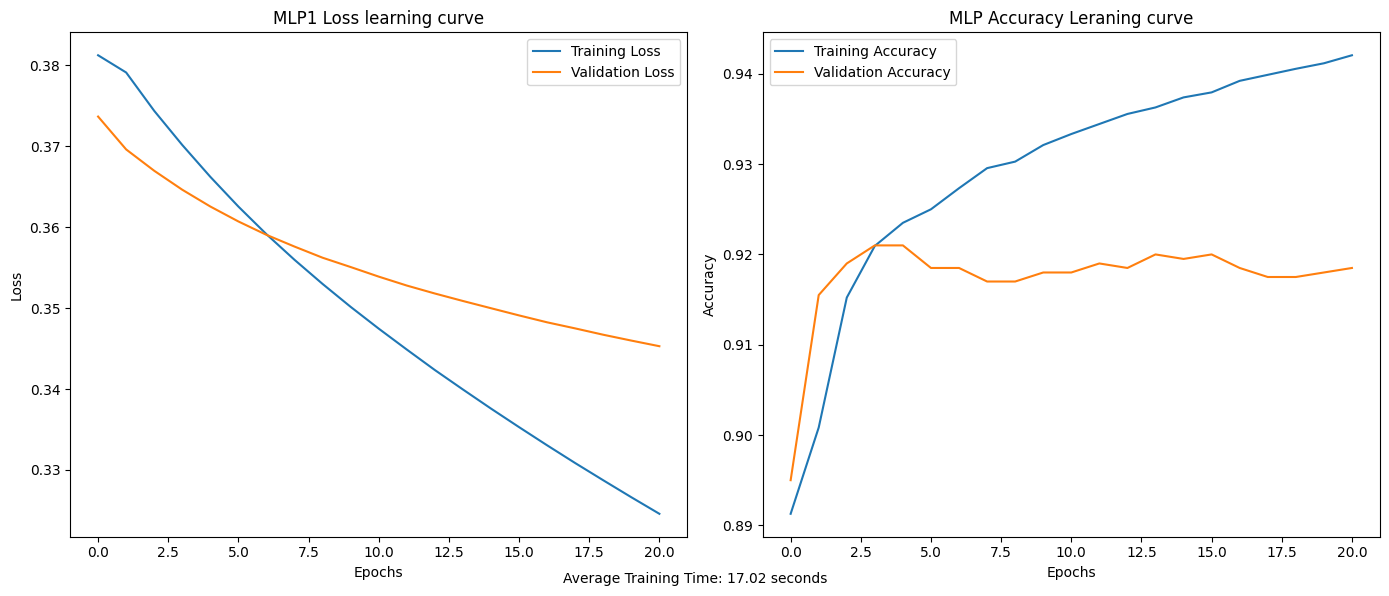

16/16 [==============================] - 0s 6ms/step


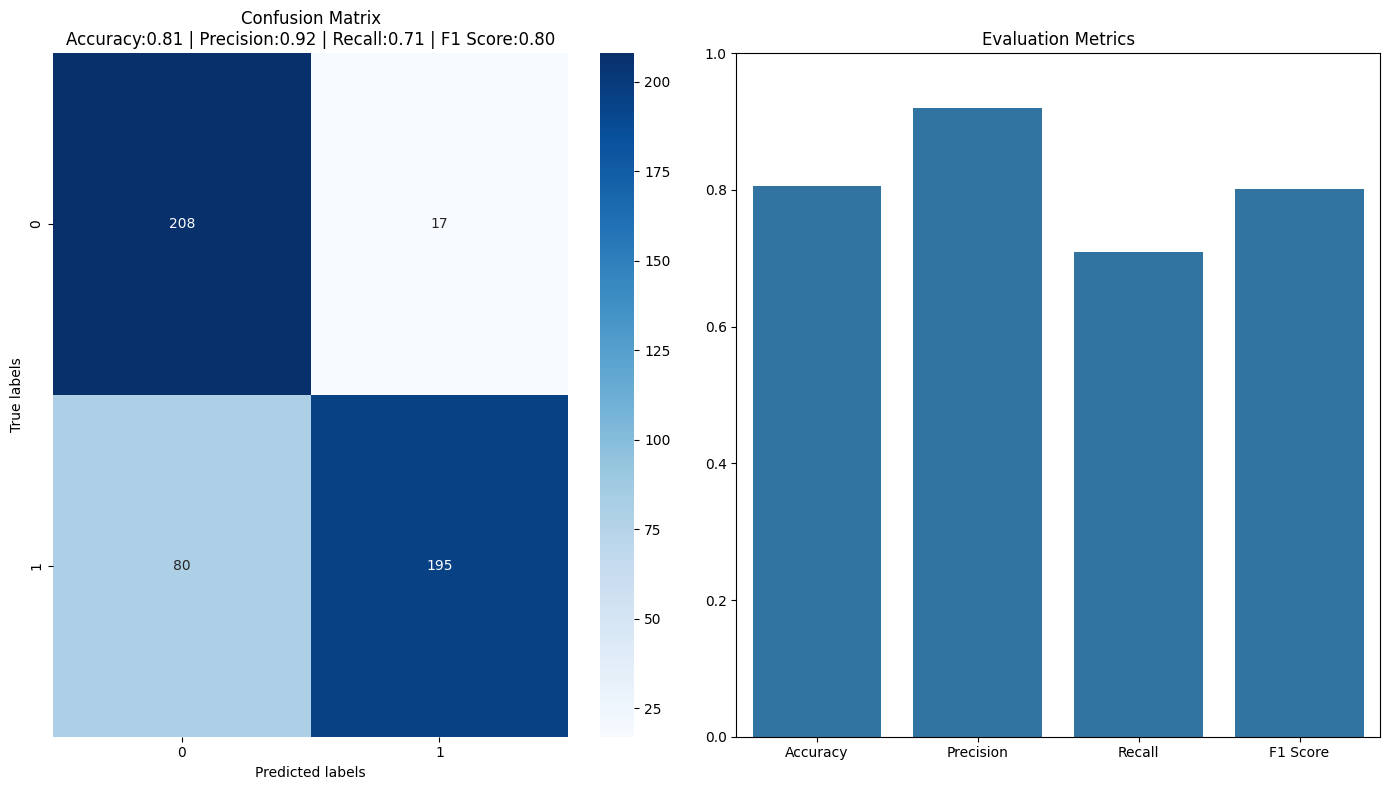

In [12]:
# Model Hyperparameters
batch_size = 32
epochs = 20 
learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 
n_folds = 10 
initializer = he_uniform(seed=42) 
regularizer = l2(0.01) 
activation = 'relu' 
loss = 'binary_crossentropy' 
hl1_size = 4 

# Create MLP1 using kfold
mlp1 = Sequential()
mlp1.add(Dense(hl1_size, activation=activation, input_shape=(max_len * 300,), kernel_regularizer=regularizer)) # hidden layer
mlp1.add(Dense(1, activation='sigmoid'))
mlp1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
mlp1, training_accuracies, training_losses, validation_accuracies, validation_losses, average_training_time  = train_model_with_kfold(mlp1, X_train_glove_embedded, y_train, n_folds, batch_size, epochs, verbose=0)
training_accuracies, training_losses, validation_accuracies, validation_losses = convert_to_arrays(training_accuracies, training_losses, validation_accuracies, validation_losses)

# Plot the learning curves
plot_learning_curves('MLP1 Loss learning curve', 'MLP Accuracy Leraning curve', training_losses.mean(axis=0), validation_losses.mean(axis=0), training_accuracies.mean(axis=0), validation_accuracies.mean(axis=0), average_training_time)

# Evaluate the model on the test data
flattened_X_test = np.reshape(X_test_glove_embedded, (X_test_glove_embedded.shape[0], -1))
MLP_predications = mlp1.predict(flattened_X_test)
evaluate_predictions(MLP_predications, y_test)

<h2><center><u><b>MLP using keras embedding layer</u></center></b></h2>

<h3><u>Constructing the embedding matrix for the Embedding layer of the MLP</u></h3>

In this phase, the embedding matrix for the Embedding layer of the MLP is constructed. This layer is pivotal as it converts tokenized training and testing sets into GloVe embeddings, which are then flattened for input into the MLP. This code iterates over each word and its corresponding index in the word index. If the word exists in the GloVe embeddings, its vector representation is retrieved and stored in the embedding matrix.

In [10]:
# Construct the model weight matrix for embedding layer
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if word in glove.key_to_index:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector

<h4><u>MLP with keras embedding layer implmenetaiton</u></h4>

This code builds an MLP model utilizing pre-trained GloVe word embeddings. Initially, hyperparameters such as batch size, epochs, and learning rate are set. The model architecture includes an Embedding layer to convert word indices into GloVe embeddings, followed by a Flatten layer. Subsequently, two Dense layers are added for classification. After compiling the model, it undergoes training using K-fold cross-validation. Learning curves are plotted to visualize training progress, and the model's performance is evaluated on test data. Finally, predictions are assessed using the evaluate_predictions function.

Fold 1/10
7/7 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.5400
Epoch 1/30
57/57 [==============================] - 2s 29ms/step - loss: 0.6900 - accuracy: 0.5983 - val_loss: 0.6863 - val_accuracy: 0.6950
Epoch 2/30
57/57 [==============================] - 2s 27ms/step - loss: 0.6776 - accuracy: 0.7350 - val_loss: 0.6729 - val_accuracy: 0.7400
Epoch 3/30
57/57 [==============================] - 1s 26ms/step - loss: 0.6606 - accuracy: 0.7678 - val_loss: 0.6601 - val_accuracy: 0.7650
Epoch 4/30
57/57 [==============================] - 2s 28ms/step - loss: 0.6444 - accuracy: 0.7906 - val_loss: 0.6484 - val_accuracy: 0.7400
Epoch 5/30
57/57 [==============================] - 2s 29ms/step - loss: 0.6294 - accuracy: 0.7972 - val_loss: 0.6372 - val_accuracy: 0.7600
Epoch 6/30
57/57 [==============================] - 2s 29ms/step - loss: 0.6152 - accuracy: 0.8089 - val_loss: 0.6268 - val_accuracy: 0.7750
Epoch 7/30
57/57 [==============================] - 2s 27ms

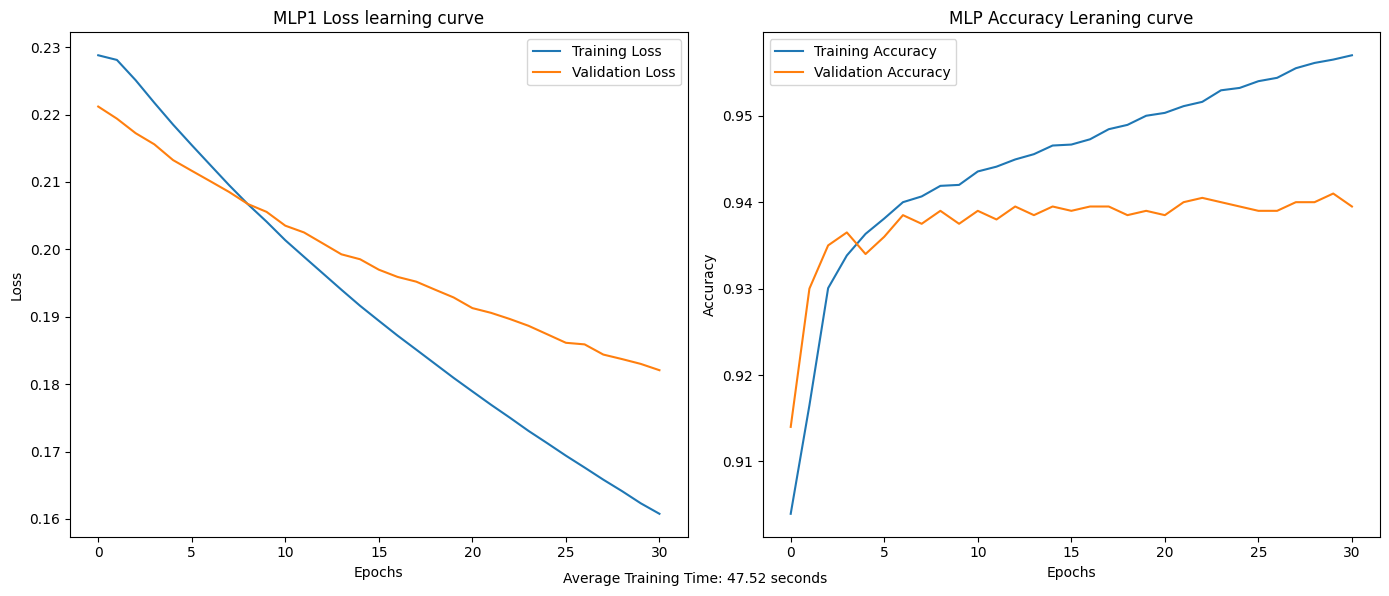

16/16 [==============================] - 0s 7ms/step


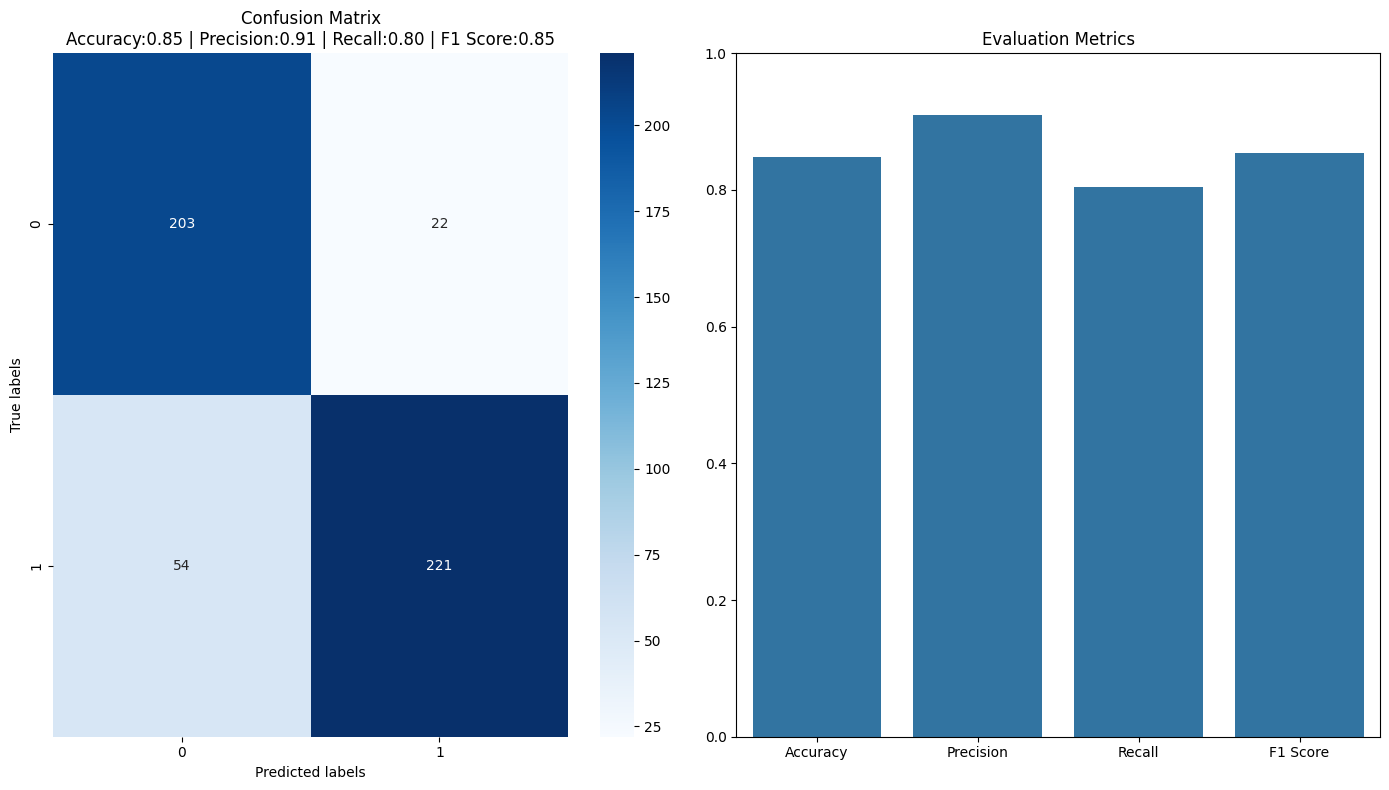

In [66]:
# Hyperparameters: MLP with Flattend glove word embeddings
batch_size = 32 
epochs = 30 
learning_rate = 0.00001 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 
n_folds = 10 
initializer = he_uniform(seed=42) 
regularizer = l2(0.01) 
activation = 'relu' 
loss = 'binary_crossentropy' 
hl1_size = 4

vocab_size = len(tokenizer.word_index) + 1

mlp2 = Sequential()
mlp2.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=True))
mlp2.add(Flatten())
mlp2.add(Dense(hl1_size, activation=activation, kernel_initializer=initializer, bias_initializer=Zeros()))
mlp2.add(Dense(1, activation='sigmoid'))
mlp2.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

mlp2, training_accuracies, training_losses, validation_accuracies, validation_losses, average_training_time  = train_model_with_kfold(mlp2, X_train, y_train, n_folds, batch_size, epochs, verbose=0)
training_accuracies, training_losses, validation_accuracies, validation_losses = convert_to_arrays(training_accuracies, training_losses, validation_accuracies, validation_losses)

# Plot the learning curves
plot_learning_curves('MLP1 Loss learning curve', 'MLP Accuracy Leraning curve', training_losses.mean(axis=0), validation_losses.mean(axis=0), training_accuracies.mean(axis=0), validation_accuracies.mean(axis=0), average_training_time)

# Evaluate the model on the test data
MLP2_predictions = mlp2.predict(X_test)
evaluate_predictions(MLP2_predictions.round(), y_test)

<h2><u><center><b>Convolutional Neural Network</b></center></u></h2>

Below is the implementation of a convolutional neural network (CNN) model. Each record is represented as a sequence of pre-trained word embedding vectors, utilizing the Keras Embedding layer.

This code sets up and trains a Convolutional Neural Network (CNN) model with predefined settings. These settings include batch size, epochs, learning rate, optimizer, validation split, initializer, regularizer, activation function, loss function, and hidden layer size. The CNN architecture consists of an Embedding layer for word embeddings, a 1D Convolutional layer with 64 filters, followed by Global Max Pooling and two Dense layers. The model is trained using K-fold cross-validation, and learning curves are plotted to monitor training progress. Finally, the model's performance is evaluated on test data.

Fold 1/10
7/7 [==============================] - 0s 13ms/step - loss: 31.0410 - accuracy: 0.5650
Epoch 1/15
29/29 [==============================] - 5s 144ms/step - loss: 20.5485 - accuracy: 0.6939 - val_loss: 10.7791 - val_accuracy: 0.7600
Epoch 2/15
29/29 [==============================] - 4s 136ms/step - loss: 5.7208 - accuracy: 0.8000 - val_loss: 1.9916 - val_accuracy: 0.7900
Epoch 3/15
29/29 [==============================] - 4s 137ms/step - loss: 1.3406 - accuracy: 0.7750 - val_loss: 0.9734 - val_accuracy: 0.7550
Epoch 4/15
29/29 [==============================] - 4s 130ms/step - loss: 0.8872 - accuracy: 0.7667 - val_loss: 0.8351 - val_accuracy: 0.7650
Epoch 5/15
29/29 [==============================] - 4s 127ms/step - loss: 0.8197 - accuracy: 0.7850 - val_loss: 0.8143 - val_accuracy: 0.8100
Epoch 6/15
29/29 [==============================] - 4s 128ms/step - loss: 0.7888 - accuracy: 0.8183 - val_loss: 0.8042 - val_accuracy: 0.8200
Epoch 7/15
29/29 [==============================]

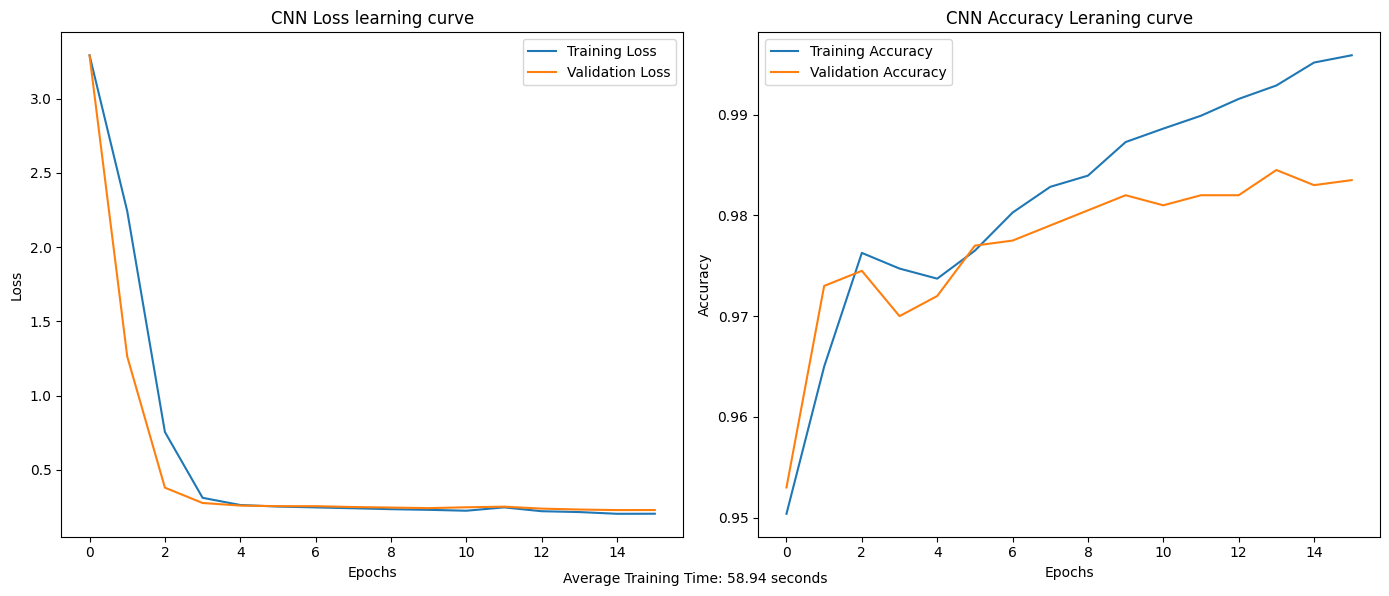

16/16 [==============================] - 0s 15ms/step


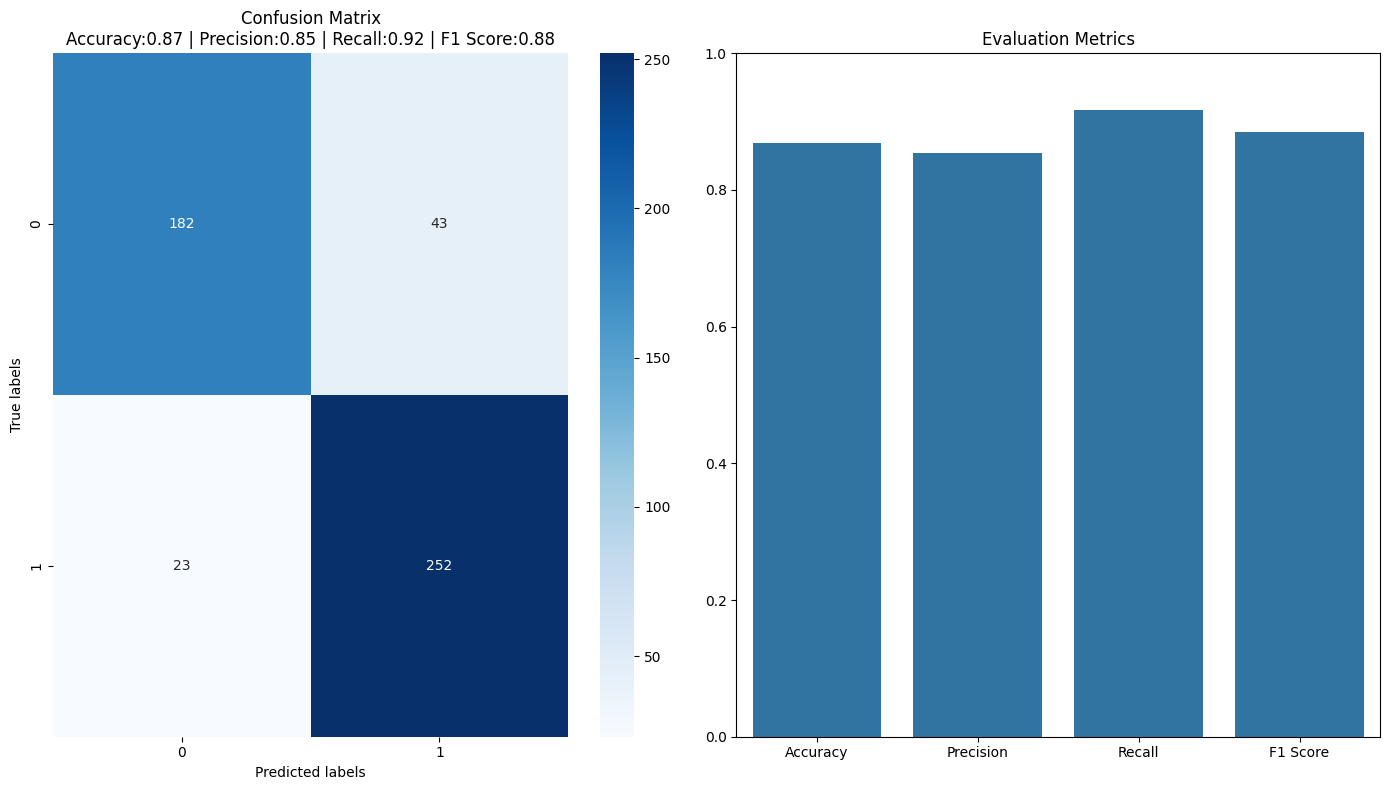

In [67]:
# Hyperparameters: MLP with Flattend glove word embeddings
batch_size = 64 # Baseline batch size # 32 is best for cnn
epochs = 15 # Baseline number of epochs
learning_rate = 0.0001 # Baseline learning rate 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Baseline optimizer
validation_split = 0.1 # Baseline validation split: 10% of the training data
initializer = he_uniform(seed=42) # Baseline initializer
regularizer = l1(0.01) # Baseline regularizer
activation = 'relu' # Baseline activation function - leaky relu, used to prevent dying relu problem as minus numbers and zeros values are a possiblity for some inputs because of dimensional spaces of embedded dimensions
loss = 'binary_crossentropy' # Baseline loss function:binary crossentropy used for binary classification model
hl1_size = 5 # Baseline number of hidden layer neurons

cnn = Sequential()
cnn.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_len, trainable=True))
cnn.add(Conv1D(64, 5, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer)) # 128 by default trying 64 instead to combat overfitting
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(4, activation=activation))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn, training_accuracies, training_losses, validation_accuracies, validation_losses, average_training_time  = train_model_with_kfold(cnn, X_train, y_train, n_folds, batch_size, epochs, verbose=0)
training_accuracies, training_losses, validation_accuracies, validation_losses = convert_to_arrays(training_accuracies, training_losses, validation_accuracies, validation_losses)

# Plot the learning curves
plot_learning_curves('CNN Loss learning curve', 'CNN Accuracy Leraning curve', training_losses.mean(axis=0), validation_losses.mean(axis=0), training_accuracies.mean(axis=0), validation_accuracies.mean(axis=0), average_training_time)

# Evaluate the model on the test data
CNN_predictions = cnn.predict(X_test)
evaluate_predictions(CNN_predictions.round(), y_test)

<h2><center><u><b>Recurrent Neural Network (RNN)</b></u></center></h2>

This code sets up and trains an RNN model for text classification. It utilizes an Embedding layer for word embeddings, followed by an LSTM layer with 68 units. The model is compiled with binary crossentropy loss and the Adam optimizer. Training is performed using K-fold cross-validation, and learning curves are plotted to monitor progress. Finally, the model's performance is evaluated on test data.

Fold 1/10
7/7 [==============================] - 0s 34ms/step - loss: 0.7204 - accuracy: 0.4100
Fold 1/10 - Training Accuracies: (0.44333332777023315, 0.6605555415153503, 0.824999988079071, 0.9172222018241882, 0.9583333134651184, 0.9872221946716309, 0.996666669845581, 0.9983333349227905, 0.9988889098167419, 0.9972222447395325, 0.9988889098167419), Validation Accuracies: (0.4099999964237213, 0.7749999761581421, 0.8050000071525574, 0.8799999952316284, 0.8600000143051147, 0.8799999952316284, 0.8650000095367432, 0.8650000095367432, 0.8550000190734863, 0.8799999952316284, 0.8799999952316284)
Fold 2/10
7/7 [==============================] - 0s 39ms/step - loss: 0.0020 - accuracy: 1.0000
Fold 2/10 - Training Accuracies: (0.9866666793823242, 0.9855555295944214, 0.9983333349227905, 0.9994444251060486, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0), Validation Accuracies: (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
Fold 3/10
7/7 [==============================] - 0s 39ms/step - loss: 2.8213e-04 

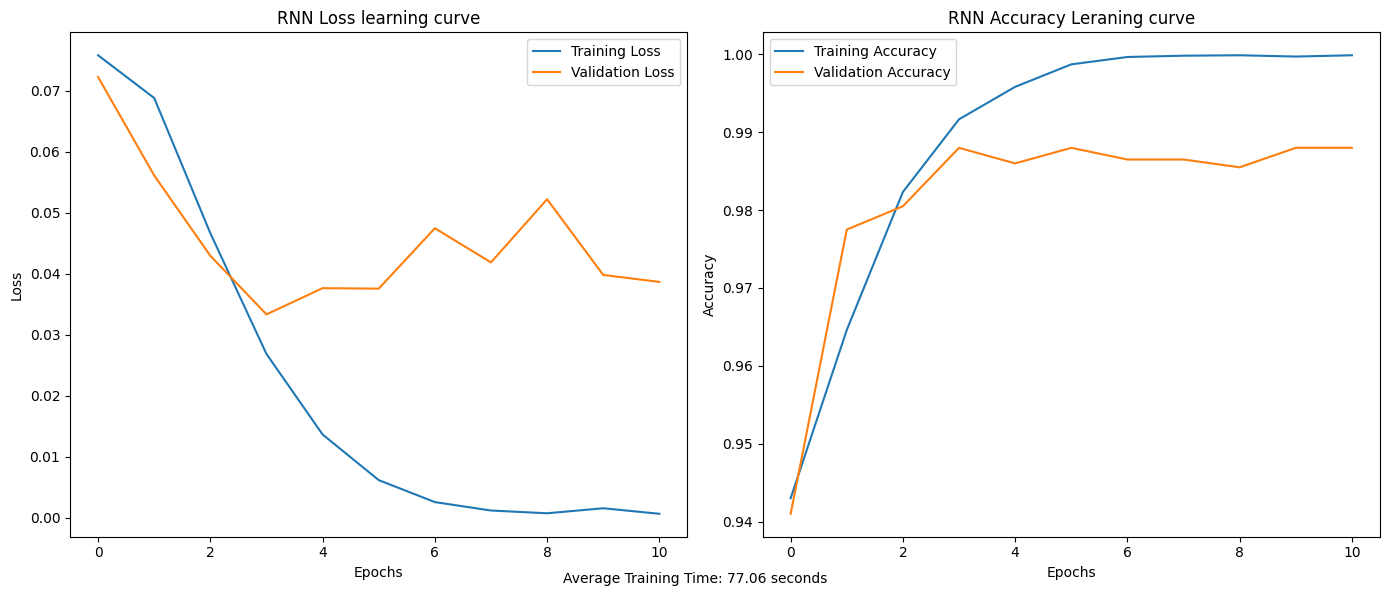

16/16 [==============================] - 1s 46ms/step


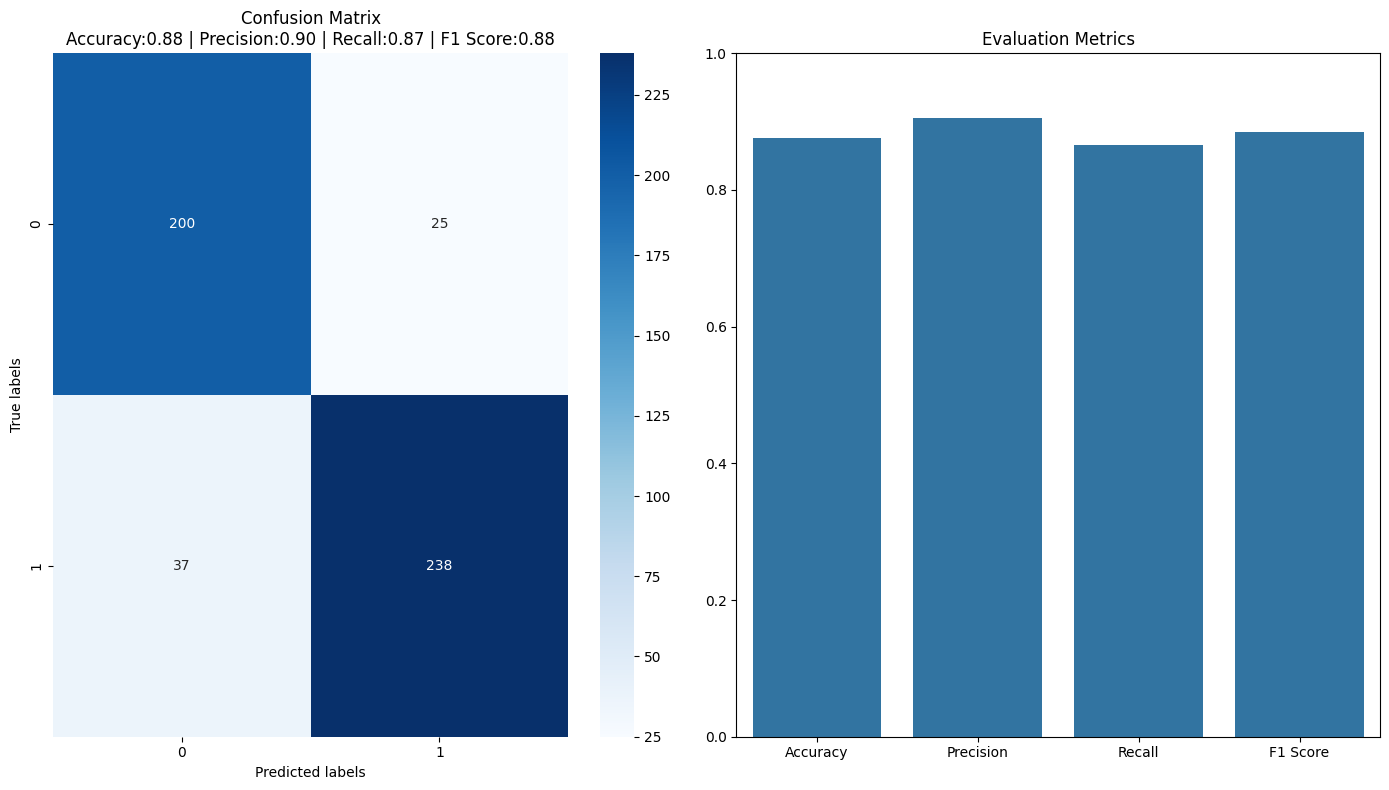

In [19]:
batch_size = 64
epochs = 10 
learning_rate = 0.0001  
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 
validation_split = 0.1 
initializer = he_uniform(seed=42) 
regularizer = l1(0.01) 
activation = 'relu' 
loss = 'binary_crossentropy' 
n_folds = 10

rnn = Sequential()
rnn.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_len, trainable=True))
rnn.add(LSTM(4, activation=activation)) # was 128 before
rnn.add(Dense(1, activation='sigmoid'))
rnn.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

rnn, training_accuracies, training_losses, validation_accuracies, validation_losses, average_training_time  = train_model_with_kfold(rnn, X_train, y_train, n_folds, batch_size, epochs, verbose=0)
training_accuracies, training_losses, validation_accuracies, validation_losses = convert_to_arrays(training_accuracies, training_losses, validation_accuracies, validation_losses)

# Plot the learning curves
plot_learning_curves('RNN Loss learning curve', 'RNN Accuracy Leraning curve', training_losses.mean(axis=0), validation_losses.mean(axis=0), training_accuracies.mean(axis=0), validation_accuracies.mean(axis=0), average_training_time)

# Evaluate the model on the test data
RNN_predications = rnn.predict(X_test)
evaluate_predictions(RNN_predications.round(), y_test)